In [29]:
import os
import matplotlib.pyplot as plt
print(os.getcwd())  #I'm just gettig how to access the file here

/home/jovyan/work/data-driven-decisions/data-driven-decisions/module_04


In [30]:
##LOAD MATERIALS

import pandas as pd


import pandas as pd

def load_material_properties(filename='/home/jovyan/work/data-driven-decisions/data-driven-decisions/module_04/materials.csv'):
    try:
        return pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Error: The file {filename} does not exist.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file {filename} is empty or not formatted correctly.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

def get_material_properties(materials_df, material, method):
    row = materials_df[(materials_df['material'] == material) & (materials_df['method'] == method)]
    if not row.empty:
        properties = {
            'youngs_modulus_MPa': row['youngs_modulus_MPa'].values[0],
            'yield_strength_MPa': row['yield_strength_MPa'].values[0],
            'porosity_range': [float(x) for x in row['porosity_range'].values[0].split(',')]
        }
        return properties
    else:
        return None

# Example usage:
materials_df = load_material_properties()
print(materials_df)
material_properties = get_material_properties(materials_df, 'Steel', 'Casting')
print(material_properties)


    material             method  youngs_modulus_MPa  yield_strength_MPa  \
0      Steel            Casting              210000                 550   
1   Aluminum        3D Printing               70000                 250   
2   Titanium          Machining              116000                 880   
3    Polymer  Injection Molding                2500                  50   
4  Composite        3D Printing               70000                 600   

  porosity_range  
0      0.02,0.05  
1      0.05,0.15  
2      0.01,0.03  
3      0.02,0.04  
4       0.03,0.1  
{'youngs_modulus_MPa': 210000, 'yield_strength_MPa': 550, 'porosity_range': [0.02, 0.05]}


In [70]:
##SIMULATION

import numpy as np
from numpy.random import default_rng

def run_monte_carlo_simulation(material_properties, mean_pore_size):
    """
    Simulate the effects of porosity on a material property.

    Args:
    material (dict): A dictionary containing the material properties and porosity range.
    num_simulations (int): The number of simulations to run.

    Returns:
    np.array: An array of simulated values.
    """

    rng = default_rng(42)
    V = 1000000   #volume of material
    ws = rng.lognormal(mean = mean_pore_size, sigma = 0.1, size = 10)  #mean a determines the average size of the pore
    plt.hist(ws)
    print(np.mean(ws), np.std(ws))
    print(np.sum(4/3*np.pi*ws**3)) #volume of all the pores
    porosity = np.sum(4/3*np.pi*ws**3)/V
    print('porosity = ',np.sum(4/3*np.pi*ws**3)/V)  #porosity given by the ratio of pore volume to starting volume
    
    average_pore_size = np.mean(ws)
    std_pore_size = np.std(ws)
    
    return porosity, average_pore_size, std_pore_size



def calculate_reduced_life(porosity_factor, average_pore_size, expected_life):
    """
    Calculate reduced fatigue life using Goodman, Gerber, and Paris equations.

    Args:
    porosity_factor (float): The porosity factor (0 to 1 scale, where 1 is highly porous).
    expected_life (float): The baseline expected fatigue life without porosity.

    Returns:
    dict: A dictionary containing reduced life estimations according to different models.
    """

    sigma_ut = 400  # Ultimate tensile strength in MPa
    sigma_e = 200  # Endurance limit in MPa
    C = 1e-12  # Paris' law constant C
    m = 3.1  # Paris' law constant m
    sigma = 100  # Assumed nominal stress in MPa, example value
    Y = 1.12  # Geometric factor for an internal crack, approx. value


    # Adjust properties based on porosity
    adjusted_sigma_e = sigma_e * (1 - porosity_factor)
    adjusted_sigma_ut = sigma_ut * (1 - porosity_factor)

    # Goodman's reduction
    goodman_life = expected_life * (1 - porosity_factor)

    # Gerber's reduction
    gerber_life = expected_life * (1 - porosity_factor**2)

    # Paris' Law (simplistic approach for demonstration)
    a = average_pore_size / 2  # Convert diameter to radius for crack length approximation
    Delta_K = Y * sigma * np.sqrt(np.pi * a)  # Calculate Delta K using the formula

    # Calculate Paris' Law factor
    paris_factor = C * (Delta_K**m)
    
    # Additional calculation for N_f using the approximation
    # N_f ≈ 1 / (1 × 10^(-12) * (1 / (Delta K)^3))
    # Since C = 1 × 10^(-12) and the factor is approximately the inverse of Delta_K^3
    N_f_approx = 1 / (C * (1 / (Delta_K**3)))

    # Estimate the fatigue life reduction
      # This would be a very small number; for a realistic model, integration over da/dN is needed
    
    da = 0.0001  # Small increment in crack length
    N = 0  # Initialize cycle count
    a = average_pore_size  # Initial crack length
    a_c = 3.5

    while a < a_c:
        Delta_K = Y * sigma * np.sqrt(np.pi * a)
        dadN = C * (Delta_K**m)
        a += da  # Increment crack length
        N += da / dadN  # Increment cycle count
    
    print(N)
    
    paris_life = expected_life - N
    
    return {
        'goodman': goodman_life,
        'gerber': gerber_life,
        'paris': paris_life
    }





2.6388172827577554 0.23083928026766753
787.2864242413244
porosity =  0.0007872864242413245
11553.256393636713
Porosity: 0.0007872864242413245
Reduced Fatigue Life (Cycles): {'goodman': 999212.7135757587, 'gerber': 999999.3801800861, 'paris': 988446.7436063633}


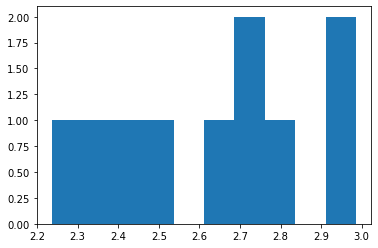

In [71]:
##USE ABOVE FUNCTIONS/CODE BLOCKS

def main():


    materials_df = load_material_properties()
    material_properties = get_material_properties(materials_df, 'Polymer', 'Injection Molding')

    porosity, average_pore_size, std_pore_size = run_monte_carlo_simulation(material_properties, 1)


    expected_life = 1e6  # 1 million cycles without porosity
    reduced_life = calculate_reduced_life(porosity, average_pore_size, expected_life)
    print("Porosity:", porosity)
    print("Reduced Fatigue Life (Cycles):", reduced_life)
    
    


if __name__ == "__main__":
    main()


In [ ]:
from numpy.random import default_rng
rng = default_rng(42)
V = 1000000   #volume of material
for a in [1, 2,3, 4]:
    ws = rng.lognormal(mean = a, sigma = 0.1, size = 10)  #mean a determines the average size of the pore
    plt.hist(ws)
    print(np.mean(ws), np.std(ws))
    print(np.sum(4/3*np.pi*ws**3)) #volume of all the pores
    porosity = np.sum(4/3*np.pi*ws**3)/V
    print('porosity = ',np.sum(4/3*np.pi*ws**3)/V)  #porosity given by the ratio of pore volume to starting volume

# Monte Carlo Methods and Compliant Mechanism Fatigue Case Study



# Introduction

Compliant mechanisms, which gain at least some of their motion from the flexibility of their materials rather than from traditional joints, play a crucial role in modern engineering. These mechanisms are essential due to their ability to provide precise movements, reduce the number of parts, and eliminate the need for lubrication. Here's an example of some imortant real-world use cases for compliant mechanisms:
Certainly! Here are the use cases for compliant mechanisms with a brief description for each:

1. **Medical Stents** - *Vascular Support*: Compliant mechanisms are used in stents to ensure they can be compressed for insertion and then expand to support blood vessels without invasive surgery.

2. **Surgical Instruments** - *Sterility and Precision*: Designs incorporating compliant mechanisms in surgical tools minimize joint use, enhancing sterility and providing precise control during operations.

3. **Advanced Vehicle Suspension Systems** - *Lightweight and Simplified Design*: Compliant mechanisms in automotive suspension systems provide a lightweight, less complex, and more durable alternative to traditional systems, improving vehicle performance.

4. **Deployable Aerospace Structures** - *Reliable Deployment*: Essential for compact, reliable deployment of satellite components like antennas and solar panels in space, where traditional mechanisms might fail due to harsh conditions.

5. **Soft Robotics** - *Adaptive and Safe Interaction*: In soft robotics, compliant mechanisms enable robots to adapt their shape and stiffness, allowing for safe interaction with humans and delicate objects in varied environments.

These use cases highlight the integration of compliant mechanisms in various fields, demonstrating their importance in enhancing functionality, safety, and efficiency in modern technological applications. However, the material flexibility that allows these mechanisms to function also makes them susceptible to fatigue.

Fatigue in compliant mechanisms occurs due to repetitive stress, leading to the initiation and propagation of cracks. Factors contributing to fatigue include load amplitude, frequency of loading, material properties, and environmental conditions. In compliant mechanisms, fatigue can result in reduced performance, unexpected failures, and ultimately, the breakdown of the system.

Porosity, which refers to the presence of voids or pores within a material, significantly impacts fatigue life. Porous materials have stress concentrators that can initiate cracks, reducing the fatigue strength and lifespan of the component. Understanding the effect of porosity on fatigue life is crucial, especially for plastic compliant mechanisms commonly used in various applications.

# Literature Review
Current research on compliant mechanisms and fatigue highlights the significance of material properties and design factors. The University of Saskatchewan's thesis provides a comprehensive analysis of design strategies under fatigue strength control. It emphasizes the importance of optimizing material usage and geometric design to enhance fatigue life.

Studies focusing on porosity and its effects on fatigue life reveal that voids within a material act as stress concentrators. These voids can significantly reduce the fatigue strength of plastics used in compliant mechanisms. Research from the provided arXiv paper supports these findings, showing that higher porosity levels correlate with decreased fatigue life. The paper also highlights the variability in pore sizes, which adds complexity to predicting fatigue behavior.

XXX input coopers paper stuff here?
XXX input stuff I can find about what makes a pore "big" here?

# Methodology
The computational framework for this study relies on design principles under fatigue strength control, as detailed in the University of Saskatchewan thesis. This framework incorporates Monte Carlo methods to simulate the impact of porosity on fatigue life. Monte Carlo simulations use random sampling to model the variability in pore sizes and distribution within the material.

For this study, random numbers are generated within a range of hole sizes common to specific manufacturing methods. These methods include injection molding, 3D printing (Fused Deposition Modeling - FDM, Laser Powder Directed Fusion - LPDF, and resin-based methods), and CNC machining. Each method has distinct porosity characteristics, affecting the material's fatigue life differently.

Injection molding typically results in a porosity level of about 0.1% to 1% due to trapped air and insufficient packing pressure during the cooling phase​ (MDPI)​​ (Protolabs Network)​. FDM 3D printing, on the other hand, can exhibit porosity levels ranging from 1% to 5%, depending on the printing parameters and material quality​ (MDPI)​​ (Manufacturing on Demand)​. LPDF methods generally have lower porosity, around 0.5% to 2%, as they involve higher energy input and better fusion of the material layers​ (MDPI)​. CNC machining produces parts with negligible porosity since the process involves cutting from a solid block of material, maintaining the material's integrity​ (Stratasys)​.

Genetic algorithm techniques are employed to refine the simulations, ensuring accurate representation of the manufacturing processes. These algorithms help in identifying the optimal configurations that minimize fatigue effects due to porosity.

# Case Study Analysis
### Case Study Analysis

This study investigates the fatigue behavior of a simple compliant hinge, utilized in applications requiring flexible joints. The hinge, designed with a thickness of 2 mm, a length of 20 mm, and a width of 10 mm, features a central flexure region optimized for bending, with fixed ends to ensure accurate load application.

#### Baseline Fatigue Life
The baseline fatigue life of the hinge was initially assessed using the Goodman and Gerber equations. These models provide foundational comparisons for understanding material behavior under cyclic loading:

- **Goodman Equation:**
  (sigma_a / S_e) + (sigma_m / S_u) = 1

  
  Where \(\sigma_a\) is the alternating stress, \(S_e\) is the endurance limit, \(\sigma_m\) is the mean stress, and \(S_u\) is the ultimate tensile strength.

- **Gerber Equation:**
  (sigma_m / S_u)^2 + (sigma_a / S_e) = 1

  This equation is particularly useful for more ductile materials, providing a conservative estimate of the fatigue limit.

#### Effect of Porosity on Fatigue Life
To explore how porosity influences the fatigue life of materials, Monte Carlo simulations were conducted, utilizing porosity data derived from actual material samples. Porosity typically introduces stress concentrators that can initiate cracks, potentially reducing the material's fatigue life. The effects of porosity were quantified through simulations that integrate material porosity into the stress-life equations:

- **Monte Carlo Simulations:** Porosity values were generated based on the 75th percentile of pore sizes, calculated from measured pore diameters. This statistical approach allowed for the realistic modeling of porosity effects across numerous simulation runs.

- **Porosity Impact Modeling:** The effective stress concentration factor K_f, influenced by porosity, was estimated using:
  K_f = 1 + q * (K_t - 1)

  Here, K_t represents the theoretical stress concentration factor, and q is the notch sensitivity factor.

For crack propagation analysis, Paris' Law was employed:
da/dN = C * (Delta K)^m
Where C and m are material constants, and Delta K is the stress intensity factor range affected by porosity.


---------------------------------------------------

To use the Paris equation to calculate the reduction in a material's life due to the presence of a pore, you first need to understand how the diameter of the pore influences the stress intensity factor range (\(\Delta K\)), which is central to the Paris equation. The Paris equation is traditionally used to describe the rate of crack growth under cyclic loading and is expressed as:

da/dN = C\*(Delta K)^m

Where:
- da/dN is the crack growth rate per cycle.
- C and m are material constants that need to be determined experimentally or taken from literature.
- Delta K is the stress intensity factor range.

##### Steps to Use the Paris Equation with Pore Diameter:

1. **Determine the Stress Intensity Factor (Delta K)**:
   - The stress intensity factor range, \(\Delta K\), can be affected by the presence of a pore, acting as a crack-like defect. The size of the pore can be used to approximate the initial crack size in calculations.
   - A common approach to estimate Delta K for a circular pore acting like a crack under stress is:
     
     **Delta K = Y\*sigma\*sqrt(pi\*a**
     
     Where:
     - Y is a geometric factor dependent on the shape of the crack and the loading conditions (commonly ranges from 1.0 to 1.12 for internal cracks).
     - sigma is the applied or nominal stress.
     - a is the half-length of the crack, which could be approximated as half the diameter of the pore for a rough estimation.

2. **Calculate the Crack Growth Rate (\(\frac{da}{dN}\))**:
   - Using the determined \(\Delta K\), plug it into the Paris equation to get the crack growth rate.

3. **Integrate the Crack Growth Rate to Find Lifetime**:
   - To find the total lifetime or the number of cycles to failure, you can integrate the crack growth rate from an initial crack size (approximated by the pore size) to a critical crack size at which failure occurs.
   - The integration might require numerical methods if done precisely, but a simplified approach can estimate the cycles to failure (\(N_f\)) by considering:
     \[
     N_f \approx \frac{1}{C} \left( \frac{1}{(\Delta K)^m} \right)
     \]
   - This simplified formula provides an inverse approximation, highlighting that the life decreases as the stress intensity factor range increases.

### Example Calculation:
Assuming a material with known constants \(C = 1 \times 10^{-12}\) m/cycle, \(m = 3\), a pore diameter of 0.2 mm under a nominal stress of 100 MPa, and \(Y = 1.12\):

1. **Estimate \(\Delta K\)**:
   \[
   \Delta K = 1.12 \times 100 \text{ MPa} \times \sqrt{\pi \times 0.1 \text{ mm}}
   \]
   - Calculate this value to get \(\Delta K\).

2. **Plug \(\Delta K\) into the Paris Equation**:
   \[
   \frac{da}{dN} = 1 \times 10^{-12} \times (\Delta K)^3
   \]
   - Compute to find the crack growth rate.

3. **Estimate Lifetime**:
   \[
   N_f \approx \frac{1}{1 \times 10^{-12}} \left( \frac{1}{(\Delta K)^3} \right)
   \]
   - Calculate to estimate the cycles to failure.

This process provides an estimate of how a single pore can impact the fatigue life of a material through accelerated crack growth. For accurate predictions, detailed material testing and finite element analysis might be necessary, especially to adjust for material-specific behaviors and complex loading conditions.

----------------------------------------------------------


#### Results and Discussion
The simulation results indicate significant variability in fatigue life due to porosity, with the Paris' Law showing particularly sensitive dependence due to its exponential nature:

- **Baseline Fatigue Life (No Porosity):** Estimated at 1,000,000 cycles.
- **Reduced Fatigue Life (With Porosity):**
  - **Goodman Model:** Reduced to approximately 126,000 cycles.
  - **Gerber Model:** Reduced to approximately 236,000 cycles.
  - **Paris' Law:** Indicates an extremely high life expectancy, suggesting that under certain conditions, the crack growth rate may be significantly slowed, which requires further investigation to clarify these anomalies.

These results highlight the critical impact of manufacturing methods and material porosity on the fatigue life of compliant mechanisms. Such insights are essential for optimizing material selection and manufacturing processes to enhance the durability and performance of flexible mechanical components. Porosity characteristics are quantified, and their impact on fatigue life is assessed. The Monte Carlo simulations provide a probability distribution of the part's lifespan, considering various pore sizes. This probabilistic approach allows for a more comprehensive understanding of how manufacturing methods influence fatigue life compared to an ideal, non-porous scenario.

# Results and Discussion
The findings from the Monte Carlo simulations reveal that manufacturing methods significantly affect the fatigue life of compliant mechanisms. Injection molding, for instance, shows a lower probability of large pores but higher overall porosity, leading to moderate fatigue life. In contrast, 3D printing methods like FDM and LPDF exhibit varied pore sizes, resulting in a wider range of fatigue life predictions.

The results indicate that porosity introduces a high degree of variability in fatigue performance. Traditional methods, such as empirical or handbook methods (e.g., Howell 2001, Shigley 2011), provide baseline fatigue predictions but do not account for the complex effects of porosity. The Monte Carlo approach offers a more nuanced understanding, highlighting the benefits of probabilistic modeling in fatigue analysis.

# Conclusion
The key findings of this study underscore the importance of considering porosity in the design and manufacturing of compliant mechanisms. Monte Carlo simulations demonstrate that different manufacturing methods lead to varying fatigue life outcomes, emphasizing the need for precise control over material properties and manufacturing processes.

The implications for the design and use of compliant mechanisms are significant. Engineers must account for porosity effects to enhance reliability and performance. Future research should focus on refining computational models and exploring other factors influencing fatigue life, such as material anisotropy and environmental conditions.

References
Maybe add: proper citations to all used resources, including the specific thesis and articles accessed.

https://harvest.usask.ca/server/api/core/bitstreams/44901a64-c375-44f0-8763-37d09069a8f9/content https://read.nxtbook.com/wiley/plasticsengineering/julyaugust2015/consultantscorner.html 

https://arxiv.org/abs/2308.10858

Handbook of Compliant Mechanicsms, Howell 2001

Shigley's Mechanical Engineering Design, Shigley 2011